# Import libraries 

In [152]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp
import orbax.checkpoint as ocp  # Checkpointing library

# Plotting libraries
import matplotlib.pyplot as plt

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Other
from IPython.display import clear_output
import os

# Set seed

In [137]:
key = jax.random.PRNGKey(42)

# Set device type

In [138]:
cpu = jax.devices("cpu")[0]
gpu = jax.devices("METAL")[0]
jax.default_device(gpu)

# Import training data

In [139]:
# Import data from local path
data = jnp.load("../data/SIM/simulations_100000_100_a_b.npy")

N = jnp.shape(data)[0]
M = (jnp.shape(data)[1]-3)//4

# Extract features
alpha  = data[:, 0]
beta   = data[:, 1]
magabs = data[:, 2]
magobs = data[:,  3:M+3]
x1     = data[:, M+3:2*M+3]
c      = data[:, 2*M+3:3*M+3]
z      = data[:, 3*M+3:4*M+3]

print(f"The file contains {N} samples of size {M}")

# del data # NEEDED IN CASE OF BIG DATAFILE

The file contains 100000 samples of size 100


# Compute residuals

In [140]:
mu_planck18, magobs, magabs = nntr.rm_cosmo(z, magobs, magabs)

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


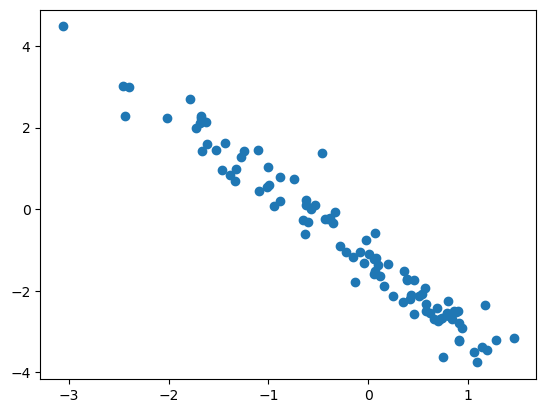

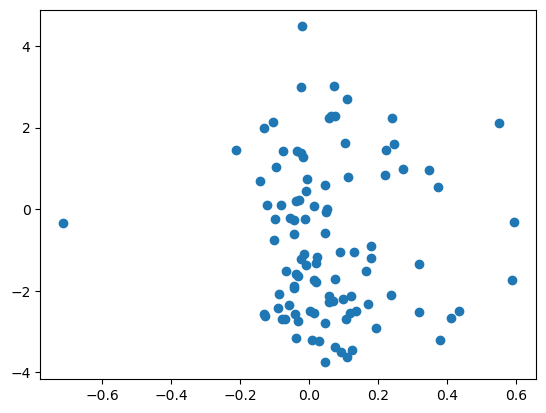

In [141]:
# Plot residuals
index = 1
plt.scatter(x1[index,:], magobs[index,:])
plt.show()
plt.scatter(c[index,:], magobs[index,:])
plt.show()

# TO DELETE

# Prepare train and test sets

## Set bounds

In [142]:
bounds = {
    'alpha': {'min':jnp.round(jnp.min(alpha),1), 'max':jnp.round(jnp.max(alpha),1)},
    'beta' : {'min':jnp.round(jnp.min(beta),1), 'max':jnp.round(jnp.max(beta),1)},
    'magabs':{'min':jnp.round(jnp.min(magabs),1), 'max':jnp.round(jnp.max(magabs),1)}
}

## Label data

In [143]:
key, lhs_key = jax.random.split(key)
lhs_false = nntr.lhs_jax(lhs_key, 3, N)
false_alpha = bounds['alpha']['min'] + (bounds['alpha']['max'] - bounds['alpha']['min']) * lhs_false[:, 0]
false_beta = bounds['beta']['min'] + (bounds['beta']['max'] - bounds['beta']['min']) * lhs_false[:, 1]
false_magabs = bounds['magabs']['min'] + (bounds['magabs']['max'] - bounds['magabs']['min']) * lhs_false[:, 2]

key, label_key = jax.random.split(key)
label_mask = jax.random.uniform(label_key, (N,)) > 0.5
alpha_masked = jnp.where(label_mask, alpha, false_alpha)
beta_masked = jnp.where(label_mask, beta, false_beta)
magabs_masked = jnp.where(label_mask, magabs, false_magabs)

## Concatenate data

In [144]:
data_flat = jnp.concatenate([
    magobs[:, :, None],
    x1[:, :, None],
    c[:, :, None]
    ], axis=2).reshape(N, 3 * M) # alternates -> [0,1,2,0,1,2,0,1,2,...]
    
inputs = jnp.concatenate([
    data_flat,
    alpha_masked[:, None],
    beta_masked[:, None],
    magabs_masked[:, None]
], axis=1)

outputs = label_mask.astype(jnp.int32)[:, None]

print("Splitting into train/test...")
key, split_key = jax.random.split(key)
train_data, test_data, train_labels, test_labels = nntr.train_test_split_jax(
    inputs, outputs, test_size=0.3, shuffle=True, key=split_key
)
print('...done')

Splitting into train/test...
...done


# Build a neural network

In [145]:
# Define the size of the different network layers
# Nsize_p = 2*M
# Nsize_r = 20*M
Nsize_p = 128
Nsize_r = 2048
phi_batch = 1

model = nntr.DeepSetClassifier(0.05, Nsize_p, Nsize_r, phi_batch, rngs=nnx.Rngs(0))

# Visualize the model structure
nnx.display(model)

In [146]:
# Initialise metrics history
metrics_history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

In [147]:
# Define the learning rate schedule
learning_rate_schedule = optax.exponential_decay(
    init_value=3e-4,
    transition_steps=1000,  # Decay every 1000 forward passes
    decay_rate=0.9,
)

momentum = 0.9 # Necessary for the Adam optimiser

# Initialize optimiser with the adaptive learning rate
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate_schedule, momentum))

# Train NN

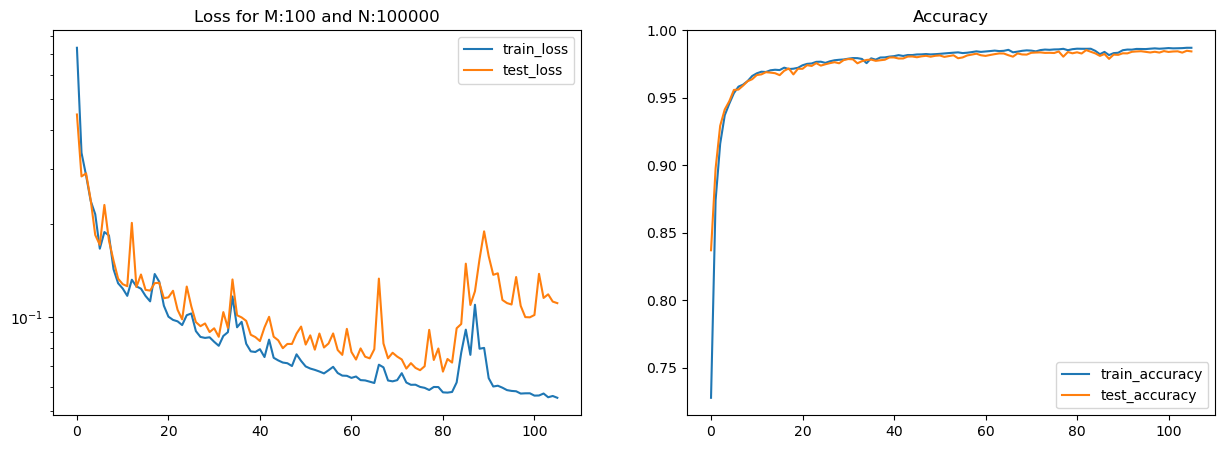


 Early stopping at epoch 111 due to 30 consecutive increases in loss gap 



In [148]:
# Early stopping parameters
patience = 30 # Number of epochs to wait for improvement
epochs = 1000 # Maximum number of epochs

batch_size = 1000

# Initialise stopping criteria
best_train_loss = jnp.inf
best_test_loss = jnp.inf
strikes = 0

model.train()
for epoch in range(epochs):
    # Shuffle the training data using JAX.
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, len(train_data))
    train_data = train_data[perm]
    train_labels = train_labels[perm]
    del perm
    
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    
    for i in range(0, len(train_data), batch_size):
        # Get the current batch of data and labels
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        
        # Perform a training step
        loss, _ = nntr.loss_fn(model, (batch_data, batch_labels))
        accuracy = nntr.accuracy_fn(model, (batch_data, batch_labels))
        epoch_train_loss += loss
        epoch_train_accuracy += accuracy
        nntr.train_step(model, optimizer, (batch_data, batch_labels))
    
    # Log the training metrics.
    current_train_loss = epoch_train_loss / (len(train_data) / batch_size)
    metrics_history['train_loss'].append(current_train_loss)
    metrics_history['train_accuracy'].append(epoch_train_accuracy/(len(train_data) / batch_size))

    epoch_test_loss = 0
    epoch_test_accuracy = 0

    # Compute the metrics on the test set using the same batching as training
    for i in range(0, len(test_data), batch_size):
        batch_data = test_data[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]

        loss, _ = nntr.loss_fn(model, (batch_data, batch_labels))
        accuracy = nntr.accuracy_fn(model, (batch_data, batch_labels))
        epoch_test_loss += loss
        epoch_test_accuracy += accuracy

    # Log the test metrics.
    current_test_loss = epoch_test_loss / (len(test_data) / batch_size)
    metrics_history['test_loss'].append(current_test_loss)
    metrics_history['test_accuracy'].append(epoch_test_accuracy/ (len(test_data) / batch_size))
    
    # Early Stopping Check
    if current_test_loss < best_test_loss:
        best_test_loss = current_test_loss  # Update best test loss
        strikes = 0
    elif current_train_loss >= best_train_loss:
        strikes = 0
    elif current_test_loss > best_test_loss and current_train_loss < best_train_loss:
        strikes +=1
    elif current_train_loss < best_train_loss:
        best_train_loss = current_train_loss # Update best train loss

    if strikes >= patience:
        print(f"\n Early stopping at epoch {epoch+1} due to {patience} consecutive increases in loss gap \n")
        break

    if epoch%5 == 0:
        #Plot loss and accuracy in subplots
        clear_output(wait=True) # Clear the output to avoid cluttering
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title(f'Loss for M:{M} and N:{N}')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax1.legend()
            ax1.set_yscale("log")
    
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
            ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
            ax2.legend()
        plt.show()

# Test NN

## Test Accuracy

In [149]:
model.eval()  # disable dropout, etc.

batch_size = 128  # tune this to fit your RAM; lower → safer

# Accumulators
all_logits = []
all_labels = []

# Loop over your test set in-place
num_samples = test_data.shape[0]
for i in range(0, num_samples, batch_size):
    xb = test_data[i : i + batch_size]
    yb = test_labels[i : i + batch_size]

    # Get logits for this mini-batch
    logits = nntr.pred_step(model, xb)
    all_logits.append(logits)

    # Store the corresponding true labels
    all_labels.append(yb > 0.5)

# Merge everything back together
all_logits = jnp.concatenate(all_logits, axis=0)
all_preds  = jsp.special.expit(all_logits) > 0.5
all_labels = jnp.concatenate(all_labels, axis=0)

# === same metrics computation as before ===
TP = jnp.sum((all_preds == 1) & (all_labels == 1))
TN = jnp.sum((all_preds == 0) & (all_labels == 0))
FP = jnp.sum((all_preds == 1) & (all_labels == 0))
FN = jnp.sum((all_preds == 0) & (all_labels == 1))

print(f"True positives : {TP}")
print(f"True negatives : {TN}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}\n")

accuracy    = (TP + TN) / (TP + TN + FP + FN)
precision   = TP / (TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy   : {accuracy:.3f}")
print(f"Precision  : {precision:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

True positives : 14980
True negatives : 14574
False positives: 385
False negatives: 61

Accuracy   : 0.985
Precision  : 0.975
Sensitivity: 0.996
Specificity: 0.974


## Test TARP

In [ ]:
# ========== Run TARP test ==========
model.eval()

BOUNDS = jnp.array([[bounds['alpha']['min'],bounds['alpha']['max']], [bounds['beta']['min'], bounds['beta']['max']]]) # Change to use directly dictionnary
NDIM = BOUNDS.shape[0]

# Select samples with true parameters in the test set
indices = jnp.where(test_labels)[0]
xy_test = test_data[indices, :3*M+2]
theta_test = test_data[indices, -NDIM:]

size = int(jnp.minimum(500, indices.shape[0]))
xy_test = xy_test[:size, :]
theta_test = theta_test[:size, :]

alpha_grid = jnp.linspace(0, 1, 50)

print("Launching MCMC (JIT‐compiled)...")
# Run the MCMC sampling on CPU for speed
# with jax.default_device(cpu):
ecp, post, key = nnte.compute_ecp_tarp_jitted(
    model, xy_test, theta_test, alpha_grid,
    n_warmup=200, n_samples=500, rng_key=key
)
print("MCMC finished")

In [ ]:
# ========== Plotting ECP vs (1 - alpha) ==========
plt.figure(figsize=(8, 6))
plt.plot(1 - alpha_grid, ecp, 'o-', label='Expected Coverage Probability (ECP)')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
plt.xlabel(r'$1 - \alpha$')
plt.ylabel("ECP")
plt.title("ECP vs $1 - \\alpha$ on Test Set (Filtered)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save NN to disk

In [150]:
ckpt_dir = os.path.abspath('../data/NNs/nn_model')
ckpt_dir = ocp.test_utils.erase_and_create_empty(ckpt_dir)

# Split the model into GraphDef (structure) and State (parameters + buffers)
_, rng_key, rng_count, state = nnx.split(model, nnx.RngKey, nnx.RngCount, ...)

# Display for debugging (optional)
nnx.display(state)

# Initialize the checkpointer
checkpointer = ocp.StandardCheckpointer()

# Save State (parameters & non-trainable variables)
checkpointer.save(ckpt_dir / 'state', state)